# MLDA-2, Spring 2022

In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, ReduceLROnPlateau, EarlyStopping


import tifffile as tiff
import matplotlib.pyplot as plt
import numpy as np

import gc
import math
import random
import time
import os

In [2]:
# constants

DATA_PATH_PREFIX = '../content/'

N_BANDS = 8    # input channel shape
N_CLASSES = 5  # buildings, roads, trees, crops and water
CLASS_WEIGHTS = [0.2, 0.3, 0.1, 0.1, 0.3]

UPCONV = True    # True to use Up-Convolutuin (=TransposedConvolution), False to use Up-Sampling
PATCH_SZ = 160  # should divide by 16

N_EPOCHS = 100
BATCH_SIZE = 32
TRAIN_SZ = 1024 # train size (for one epoch)
VAL_SZ = 1000  # validation size


Create a function generating network with given architecture. 

In [3]:
def unet_model(n_classes=5, im_sz=160, n_channels=8, n_filters_start=32, growth_factor=2, upconv=True,
               class_weights=[0.2, 0.3, 0.1, 0.1, 0.3]):
    n_filters = n_filters_start
    inputs = Input((im_sz, im_sz, n_channels))
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)
    outputs = Conv2D(n_classes, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[inputs], outputs=[outputs])
    
    def weighted_binary_crossentropy(y_true, y_pred):
        class_loglosses = K.mean(K.binary_crossentropy(y_true, y_pred), axis=[0, 1, 2])
        return K.sum(class_loglosses * K.constant(class_weights))

    model.compile(optimizer=Adam(), loss=weighted_binary_crossentropy)
    return model

It is recommended not to feed whole satellite images to the network. <br>
Instead, resample small patches of size $160 \times 160$ and train the model with such samples. <br>
This is a common practice in image segmentation.

Create U-Net model using function `unet_model()` and see its summary:

In [4]:
model = unet_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 8  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 160, 160, 16  1168        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 160, 160, 16  0           ['conv2d[0][0]']                 
                                )                                                             

The output is created with 5 channels - one per segmentation class. Each channel will contain probabilities of pixel belonging to the corresponding class.

Plot the neural network architecture:

Before training network normalize the images, so that all values are in [-1.0,1.0]. <br>
Create function that does that.

In [5]:
def normalize(img):
    min = img.min()
    max = img.max()
    return 2.0 * (img - min) / (max - min) - 1.0


Read train data, normalize it and make channels last. Split validation data.

In [6]:
import cv2
# all availiable ids: from "01" to "24":
trainIds = [str(i).zfill(2) for i in range(1, 25)]  

X_DICT_TRAIN = dict()
Y_DICT_TRAIN = dict()
X_DICT_VALIDATION = dict()
Y_DICT_VALIDATION = dict()

print('Reading images')
for img_id in trainIds:
    img_m = normalize(tiff.imread(f'{DATA_PATH_PREFIX}/mbandd/{img_id}.tif').transpose([1, 2, 0]))
    mask = tiff.imread(f'{DATA_PATH_PREFIX}/gt-mbandd/{img_id}.tif').transpose([1, 2, 0])/255
    train_xsz = int(0.75 * img_m.shape[0])  # use 75% of image as train and 25% for validation
    X_DICT_TRAIN[img_id] = img_m[:train_xsz, :, :]
    Y_DICT_TRAIN[img_id] = mask[:train_xsz, :, :]
    X_DICT_VALIDATION[img_id] = img_m[train_xsz:, :, :]
    Y_DICT_VALIDATION[img_id] = mask[train_xsz:, :, :]
    print(img_id + ' read')
print('Images were read')

gc.collect();

Reading images
01 read
02 read
03 read
04 read
05 read
06 read
07 read
08 read
09 read
10 read
11 read
12 read
13 read
14 read
15 read
16 read
17 read
18 read
19 read
20 read
21 read
22 read
23 read
24 read
Images were read


We need to prepare 160x160 patches from both train and validation data to fit the model.

The following function `get_rand_patch()` picks random patch from an image and corresponding mask.
Then function `get_patches()` resamples patches from the train or validataion set.

In [7]:
def get_rand_patch(img, mask, sz=PATCH_SZ):
    """
    :param img: ndarray with shape (x_sz, y_sz, num_channels)
    :param mask: ndarray with shape (x_sz, y_sz, num_classes)
    :param sz: size of random patch
    :returns: patch with shape (sz, sz, num_channels)
    """
    assert len(img.shape) == 3 and img.shape[0] > sz and img.shape[1] > sz and img.shape[0:2] == mask.shape[0:2]
    xc = random.randint(0, img.shape[0] - sz)
    yc = random.randint(0, img.shape[1] - sz)
    patch_img = img[xc:(xc + sz), yc:(yc + sz)]
    patch_mask = mask[xc:(xc + sz), yc:(yc + sz)]
    return patch_img, patch_mask


def get_patches(x_dict, y_dict, n_patches, sz=PATCH_SZ):
    start_time = time.process_time()
    x = list()
    y = list()
    total_patches = 0
    while total_patches < n_patches:
        img_id = random.sample(x_dict.keys(), 1)[0]
        img = x_dict[img_id]
        mask = y_dict[img_id]
        img_patch, mask_patch = get_rand_patch(img, mask, sz)
        x.append(img_patch)
        y.append(mask_patch)
        total_patches += 1
    print(f'Generated {total_patches} patches @ {time.process_time() - start_time:.4f} seconds')
    return np.array(x), np.array(y)

# generator
def gen_patches(x_dict, y_dict, n_patches, sz=PATCH_SZ):
    while(True):
        gc.collect()
        yield get_patches(x_dict, y_dict, n_patches, sz=PATCH_SZ)

Create path for weights.

In [8]:
weights_path = 'weights'
if not os.path.exists(weights_path):
    os.makedirs(weights_path)
weights_path += '/unet_weights.hdf5'

#if os.path.isfile(weights_path):
#    model.load_weights(weights_path)

Train network.

In [9]:
print("start training net")

x_val, y_val = get_patches(X_DICT_VALIDATION, Y_DICT_VALIDATION, n_patches=VAL_SZ, sz=PATCH_SZ)
callbacks = []
callbacks.append(ModelCheckpoint(weights_path, monitor='val_loss', save_best_only=True))
callbacks.append(CSVLogger('log_unet.csv', append=True, separator=';'))
#callbacks.append(TensorBoard(log_dir='./tensorboard_unet/', write_graph=True, write_images=True))
callbacks.append(EarlyStopping(patience=5, verbose=1))
callbacks.append(ReduceLROnPlateau(patience=3, verbose=1))

train_gen = gen_patches(X_DICT_TRAIN, Y_DICT_TRAIN, n_patches=BATCH_SIZE, sz=PATCH_SZ)

model.fit(train_gen, steps_per_epoch = TRAIN_SZ//BATCH_SIZE, 
          batch_size=BATCH_SIZE, epochs=N_EPOCHS,
              verbose=2, shuffle=False,
              callbacks=callbacks,
              validation_data=(x_val, y_val))

start training net
Generated 1000 patches @ 0.0104 seconds
Generated 32 patches @ 0.0003 seconds
Epoch 1/100
Generated 32 patches @ 0.0010 seconds
Generated 32 patches @ 0.0004 seconds
Generated 32 patches @ 0.0004 seconds
Generated 32 patches @ 0.0003 seconds
Generated 32 patches @ 0.0003 seconds
Generated 32 patches @ 0.0004 seconds
Generated 32 patches @ 0.0010 seconds
Generated 32 patches @ 0.0003 seconds
Generated 32 patches @ 0.0004 seconds
Generated 32 patches @ 0.0003 seconds
Generated 32 patches @ 0.0005 seconds
Generated 32 patches @ 0.0003 seconds
Generated 32 patches @ 0.0008 seconds
Generated 32 patches @ 0.0003 seconds
Generated 32 patches @ 0.0003 seconds
Generated 32 patches @ 0.0003 seconds
Generated 32 patches @ 0.0004 seconds
Generated 32 patches @ 0.0005 seconds
Generated 32 patches @ 0.0011 seconds
Generated 32 patches @ 0.0006 seconds
Generated 32 patches @ 0.0003 seconds
Generated 32 patches @ 0.0003 seconds
Generated 32 patches @ 0.0003 seconds
Generated 32 patc

## Prediction

The following function takes: 
- image *'x'* 
- trained model 
- patch size 
- number of classes

It returns predicted probabilities of each class for every pixel of *'x'* in array with shape `(extended_height, extended_width, n_classes)`, where `extended_height` and `extended_width` are extended dimensions of `x` that make whole number of patches in the image.

In [10]:
def predict(x, model, patch_sz=PATCH_SZ, n_classes=N_CLASSES):
    img_height = x.shape[0]
    img_width = x.shape[1]
    n_channels = x.shape[2]

    # make extended img so that it contains integer number of patches
    npatches_vertical = math.ceil(img_height/patch_sz)
    npatches_horizontal = math.ceil(img_width/patch_sz)
    extended_height = patch_sz * npatches_vertical
    extended_width = patch_sz * npatches_horizontal
    ext_x = np.zeros(shape=(extended_height, extended_width, n_channels), dtype=np.float32)
    # fill extended image with mirror reflections of neighbors:
    ext_x[:img_height, :img_width, :] = x
    for i in range(img_height, extended_height):
        ext_x[i, :, :] = ext_x[2*img_height - i - 1, :, :]
    for j in range(img_width, extended_width):
        ext_x[:, j, :] = ext_x[:, 2*img_width - j - 1, :]

    # now assemble all patches in one array
    patches_list = []
    for i in range(0, npatches_vertical):
        for j in range(0, npatches_horizontal):
            x0, x1 = i * patch_sz, (i + 1) * patch_sz
            y0, y1 = j * patch_sz, (j + 1) * patch_sz
            patches_list.append(ext_x[x0:x1, y0:y1, :])
    # model.predict() needs numpy array rather than a list
    patches_array = np.asarray(patches_list)
    # predictions:
    patches_predict = model.predict(patches_array, batch_size=4)
    prediction = np.zeros(shape=(extended_height, extended_width, n_classes), dtype=np.float32)
    for k in range(patches_predict.shape[0]):
        i = k // npatches_horizontal
        j = k % npatches_vertical
        x0, x1 = i * patch_sz, (i + 1) * patch_sz
        y0, y1 = j * patch_sz, (j + 1) * patch_sz
        prediction[x0:x1, y0:y1, :] = patches_predict[k, :, :, :]
    return prediction[:img_height, :img_width, :]

Note that method `predict()` in the cell above uses `batch_size`. Batch prediction is usually used when data set to be predicted is very large and may not fit in memory. In such case prediction will be done batch by batch.

Show image of the created mask. <br>
On this image use color codes of the first 5 colors for the 5 classes. <br>
Create function that takes a mask created by *'predict()'* and a threshold and returns an RGB file that can be shown by *'imshow()'*. <br>

In function *'picture_from_mask()'* created below:
- Dictionary variable *'colors'* contains first 5 colors corresponding to the 5 classes of objects. Color of each class is defined as combination of 3 basic colors
- Dictionary *'z_order'* creates special order of classes in which the mask-image is created. If the same pixel has high enough probability of belonging to several classes then the pixel is marked as highest of them in *'z_order'*. Basically, this means that in the loop over *'z_order'* color of the next significant class replaces the color of the previous one.
- A class of a pixel is considered "significant" if probability of that class is greater than "threshold".

In [11]:
def picture_from_mask(mask, threshold=0):
    colors = {
        0: [150, 150, 150],  # Buildings
        1: [223, 194, 125],  # Roads & Tracks
        2: [27, 120, 55],    # Trees
        3: [166, 219, 160],  # Crops
        4: [116, 173, 209]   # Water
    }
    z_order = {
        1: 3,
        2: 4,
        3: 0,
        4: 1,
        5: 2
    }
    pict = 255*np.ones(shape=(3, mask.shape[1], mask.shape[2]), dtype=np.uint8)
    for i in range(1, 6):
        cl = z_order[i]
        for ch in range(3):
            pict[ch,:,:][mask[cl,:,:] > threshold] = colors[cl][ch]
    return pict

Read test image, normalize it and make predictions.

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f6c10fd3450>)

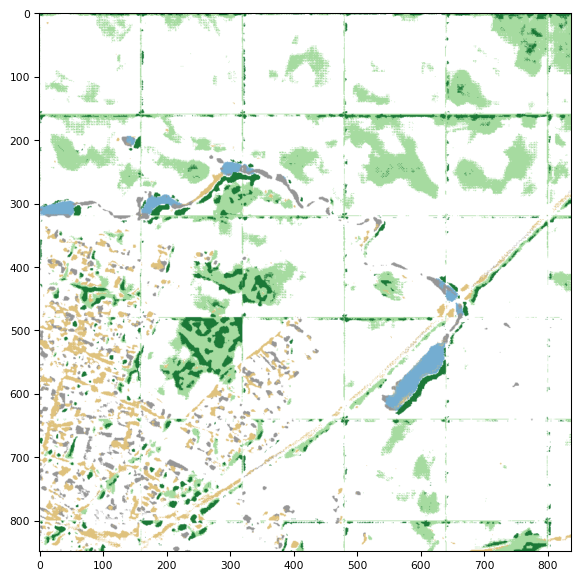

In [12]:
test_id = 'test'

img = normalize(tiff.imread(f'{DATA_PATH_PREFIX}/mbandd/{test_id}.tif')).transpose([1,2,0])  # make channels last
mask = predict(img, model, patch_sz=PATCH_SZ, n_classes=N_CLASSES).transpose([2,0,1])  # make channels first
map_ = picture_from_mask(mask, threshold=0.3)
tiff.imsave('result.tif', (255*mask).astype('uint8'))
tiff.imsave('map.tif', map_)

tiff.imshow(map_)